In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_csv(file):
    df = pd.read_csv(file, parse_dates=True, index_col=0)
    return df

## XGBoost for Nature + Kalman imputed dataset


In [26]:
X_train = read_csv('output/\CompleteDengueNatureKalmanTrain_0.csv')
X_test = read_csv('output/\CompleteDengueNatureKalmanTest_0.csv')

y = pd.read_csv('input/\dengue_labels_train.csv', parse_dates=True)

y = y.groupby(['year', 'weekofyear']).sum()
y_train = y.iloc[:734]
y_train = pd.DataFrame(index = X_train.index, data = y_train.total_cases.values)
y_test = y.iloc[734:]
y_test = pd.DataFrame(index = X_test.index, data = y_test.total_cases.values)


xgb_model = xgb.XGBClassifier(objective="reg:squarederror",
                                  eval_metric = 'rmse',
                                  max_depth=3,
                                  n_estimators=500,
                                  learning_rate=0.5
                              )
model = xgb_model.fit(X_train, y_train)

y_pred = model.predict(X_test)

MSE = mse(y_test, y_pred)
RMSE = np.sqrt(MSE)

print("\nRMSE: ", np.round(RMSE, 2))


RMSE:  26.73


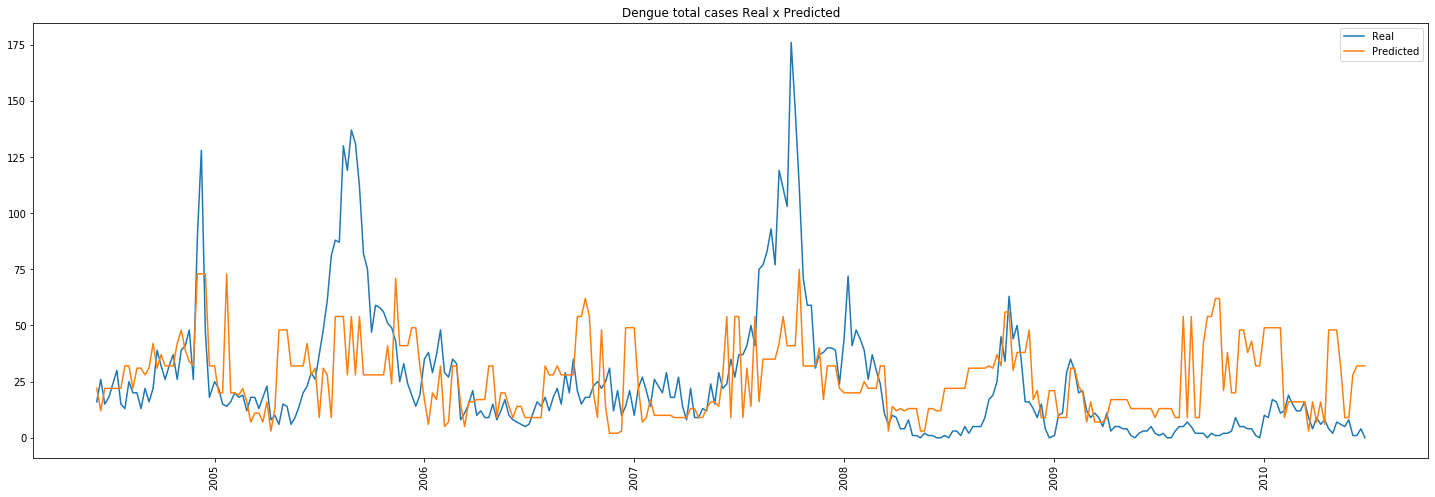

In [27]:
plt.figure(figsize=(25, 8))
plt.plot(y_test.index, y_test.values, label='Real')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title("Dengue total cases Real x Predicted")
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [33]:
def run_experiment_multiple_times(n=30):
    result_dict = {}
    result_dict= {'rmse':0, 'best_model':None, 'best_rmse':999999999999}
    list_rmse = []
    for i in range(0,n):
        X_train = read_csv('output/\CompleteDengueNatureKalmanTrain_'+str(i)+'.csv')
        X_test = read_csv('output/\CompleteDengueNatureKalmanTest_'+str(i)+'.csv')

        y = pd.read_csv('input/\dengue_labels_train.csv', parse_dates=True)

        y = y.groupby(['year', 'weekofyear']).sum()
        y_train = y.iloc[:734]
        y_train = pd.DataFrame(index = X_train.index, data = y_train.total_cases.values)
        y_test = y.iloc[734:]
        y_test = pd.DataFrame(index = X_test.index, data = y_test.total_cases.values)


        xgb_model = xgb.XGBClassifier(objective="reg:squarederror",
                                          eval_metric = 'rmse',
                                          max_depth=3,
                                          n_estimators=500,
                                          learning_rate=0.5
                                      )
        model = xgb_model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        MSE = mse(y_test, y_pred)
        RMSE = np.sqrt(MSE)
        list_rmse.append(RMSE)
        print('Round', i, "rmse", RMSE)
        result_dict['rmse'] += RMSE
        if result_dict['best_rmse'] > RMSE:
            result_dict['best_rmse'] = RMSE
            result_dict['best_model'] = model
    print("STD RMSE", np.std(list_rmse, axis=0))
    result_dict['rmse'] = result_dict['rmse']/n
    return result_dict     

In [34]:
result_dict = run_experiment_multiple_times(n=30)

Round 0 rmse 26.725708448299216
Round 1 rmse 26.695044424488167
Round 2 rmse 28.40456033138073
Round 3 rmse 26.725708448299216
Round 4 rmse 26.725708448299216
Round 5 rmse 27.67825345439474
Round 6 rmse 26.725708448299216
Round 7 rmse 26.695044424488167
Round 8 rmse 26.725708448299216
Round 9 rmse 26.695044424488167
Round 10 rmse 26.725708448299216
Round 11 rmse 26.725708448299216
Round 12 rmse 28.40456033138073
Round 13 rmse 27.67825345439474
Round 14 rmse 27.67825345439474
Round 15 rmse 27.67825345439474
Round 16 rmse 26.725708448299216
Round 17 rmse 27.67825345439474
Round 18 rmse 28.40456033138073
Round 19 rmse 27.67825345439474
Round 20 rmse 27.67825345439474
Round 21 rmse 26.725708448299216
Round 22 rmse 28.40456033138073
Round 23 rmse 27.67825345439474
Round 24 rmse 28.40456033138073
Round 25 rmse 28.40456033138073
Round 26 rmse 26.725708448299216
Round 27 rmse 28.40456033138073
Round 28 rmse 26.695044424488167
Round 29 rmse 27.67825345439474
STD RMSE 0.6902978108806288


In [35]:
result_dict

{'rmse': 27.39911551967208,
 'best_model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
               gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.5, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=500, n_jobs=0,
               num_parallel_tree=1, objective='multi:softprob', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None),
 'best_rmse': 26.695044424488167}